# Exploratory Data Analysis (EDA) – Brain MRI Tumor Dataset

Este notebook presenta un análisis exploratorio inicial del dataset de imágenes MRI
utilizado para la clasificación de tumores cerebrales.

El objetivo del EDA es comprender la estructura del dataset, la distribución de clases
y posibles aspectos relevantes a considerar antes del entrenamiento de modelos
de Deep Learning.


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter
from PIL import Image

In [29]:
from pathlib import Path
import os

def set_project_root(marker_dir="data"):
    """
    Ajusta el working directory al root del proyecto de forma segura.
    El root se identifica por la presencia de una carpeta 'marker_dir'.
    """
    cwd = Path.cwd()

    if (cwd / marker_dir).exists():
        # Ya estamos en el root
        return cwd

    for parent in cwd.parents:
        if (parent / marker_dir).exists():
            os.chdir(parent)
            return parent

    raise RuntimeError("No se pudo encontrar el directorio raíz del proyecto.")

PROJECT_ROOT = set_project_root()
print("Working directory:", Path.cwd())





Working directory: c:\Users\USUARIO\Documents\Mestria IA\Proyecto_gradio\Repo Proyecto\brain-mri-tumor-classification


In [31]:
# Cargar dataset
df = pd.read_csv("data/processed/dataset.csv")

df.head()

,img_path,label
0,data/raw/brain-tumor-mri-scans/meningioma/0289...,meningioma
1,data/raw/brain-tumor-mri-scans/healthy/0841.jpg,healthy
2,data/raw/brain-tumor-mri-scans/healthy/1258.jpg,healthy
3,data/raw/brain-tumor-mri-scans/meningioma/1600...,meningioma
4,data/raw/brain-tumor-mri-scans/pituitary/1629.jpg,pituitary


In [32]:
label_counts = df["label"].value_counts()
label_counts.sum()

7023

In [33]:
# Valores únicos de las etiquetas
df["label"].unique()

array(['meningioma', 'healthy', 'pituitary', 'glioma'], dtype=object)

In [34]:
# Ver si hay valores nulos
df.isnull().sum()

img_path    0
label       0
dtype: int64

El dataset contiene un total de 7023 imágenes distribuidas en cuatro clases:
glioma, meningioma, pituitary y healthy en donde no existen datos nulos

In [35]:
df["img_path"].str.len().describe()


count    7023.000000
mean       47.972234
std         1.547482
min        46.000000
25%        47.000000
50%        47.000000
75%        49.000000
max        50.000000
Name: img_path, dtype: float64

Las rutas de imágenes presentan longitudes consistentes, lo que sugiere una
estructura homogénea del dataset.

In [36]:
(label_counts / label_counts.sum() * 100).round(2)

label
healthy       28.48
pituitary     25.02
meningioma    23.42
glioma        23.08
Name: count, dtype: float64

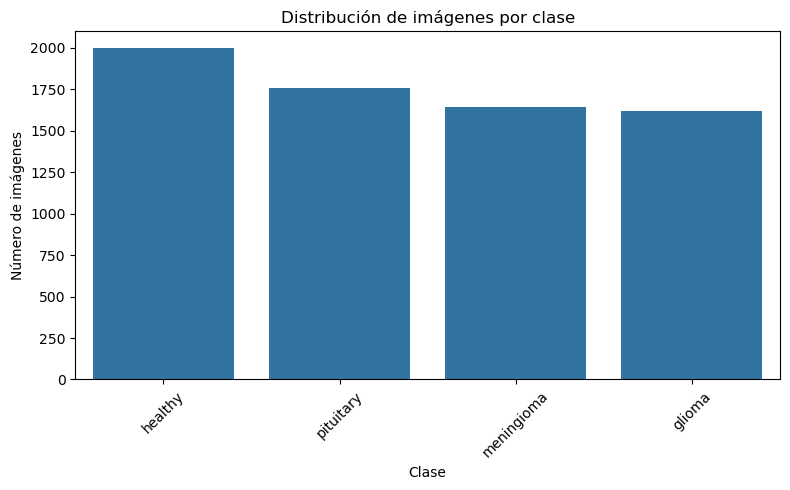

In [37]:
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribución de imágenes por clase")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


La distribución de clases es relativamente balanceada. La clase *healthy*
presenta una ligera mayor cantidad de imágenes, pero no se observa un
desbalance severo que requiera técnicas de re-muestreo.

In [38]:
sample_df = (
    df.groupby("label", group_keys=False)
      .head(3)
      .reset_index(drop=True)
)

sample_df


,img_path,label
0,data/raw/brain-tumor-mri-scans/meningioma/0289...,meningioma
1,data/raw/brain-tumor-mri-scans/healthy/0841.jpg,healthy
2,data/raw/brain-tumor-mri-scans/healthy/1258.jpg,healthy
3,data/raw/brain-tumor-mri-scans/meningioma/1600...,meningioma
4,data/raw/brain-tumor-mri-scans/pituitary/1629.jpg,pituitary
5,data/raw/brain-tumor-mri-scans/pituitary/0186.jpg,pituitary
6,data/raw/brain-tumor-mri-scans/healthy/0552.jpg,healthy
7,data/raw/brain-tumor-mri-scans/glioma/1566.jpg,glioma
8,data/raw/brain-tumor-mri-scans/glioma/1608.jpg,glioma
9,data/raw/brain-tumor-mri-scans/pituitary/0575.jpg,pituitary


Se seleccionaron tres imágenes por clase para realizar una inspección visual
cualitativa del dataset.

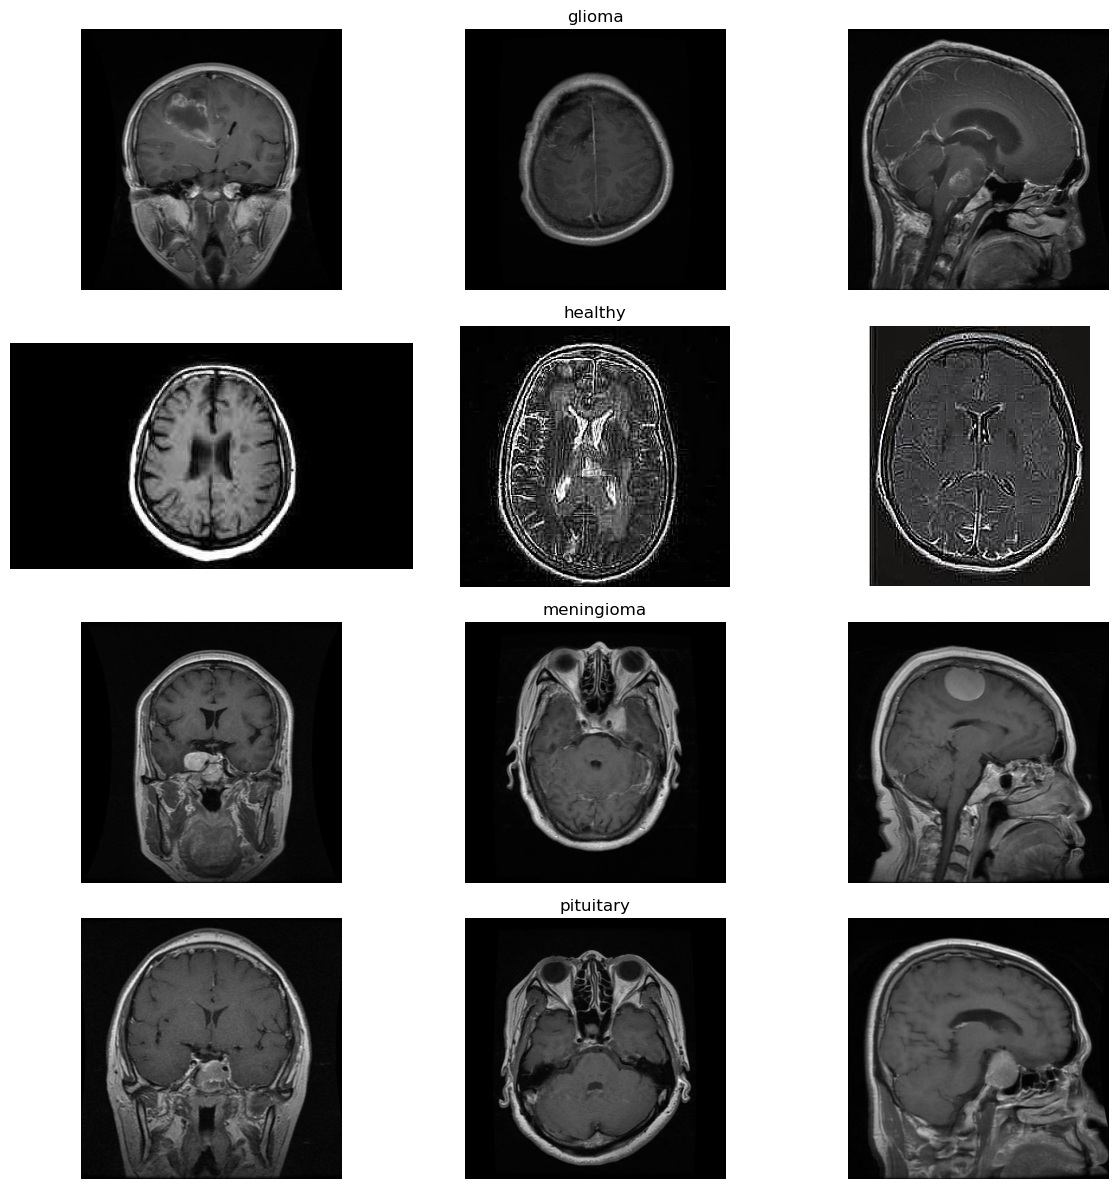

In [39]:
from PIL import Image

num_classes = sample_df["label"].nunique()
fig, axes = plt.subplots(num_classes, 3, figsize=(12, 3 * num_classes))

for i, (label, group) in enumerate(sample_df.groupby("label")):
    for j, (_, row) in enumerate(group.iterrows()):
        img = Image.open(row["img_path"]).convert("RGB")
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if j == 1:
            axes[i, j].set_title(label)

plt.tight_layout()
plt.show()


### Observaciones visuales

- Las imágenes presentan variabilidad en tamaño y resolución.
- Visualmente, muchas imágenes parecen estar en escala de grises o con baja
  saturación, lo cual es consistente con imágenes MRI.
- Se observa coherencia visual dentro de cada clase.

### Dimensión de las imágenes 

El análisis exploratorio evidenció variabilidad en las dimensiones originales de las imágenes MRI, con predominancia de resoluciones de 512×512 píxeles, aunque también se identificaron imágenes con tamaños y proporciones distintas. Se requieres estándarizar.

In [41]:
sizes = sample_df["img_path"].apply(
    lambda p: Image.open(p).size
)
Counter(sizes).most_common(5)

[((512, 512), 9), ((300, 168), 1), ((228, 221), 1), ((206, 244), 1)]

### Formato de las imágenes
Las imágenes se encuentran almacenadas en formato RGB, pese a tratarse de imágenes de resonancia magnética originalmente monocromáticas. Esta representación facilita la aplicación de técnicas de transfer learning sin necesidad de adaptar la arquitectura de entrada de los modelos.

In [42]:
img = Image.open(sample_df.iloc[0]["img_path"])
img.mode

'RGB'

### Distribución de la intensidad de los pixeles

El análisis de la distribución de intensidades de píxeles muestra una concentración significativa en valores bajos, correspondiente al fondo de las imágenes, así como una distribución más dispersa en intensidades medias asociadas al tejido cerebral. Este comportamiento es consistente con imágenes MRI. Se deben normalizar.

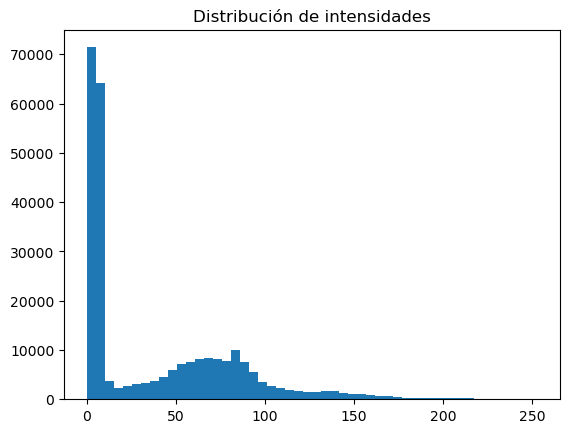

In [46]:
img = np.array(Image.open(sample_df.iloc[0]["img_path"]).convert("L"))
plt.hist(img.flatten(), bins=50)
plt.title("Distribución de intensidades")
plt.show()

### Conclusión

En conjunto, la exploración de los datos permitió identificar características estructurales y estadísticas propias de imágenes MRI, así como posibles retos asociados a la heterogeneidad de tamaños y distribución de intensidades. Estos hallazgos orientaron directamente las decisiones de preprocesamiento y selección de modelos.